# Lab 3: PCR and PLS Regression

### Principal Components Regression (PCR)

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA # Principle Component Analysis
from sklearn.preprocessing import StandardScaler # Feature Scaling
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline # Make pipe line
from sklearn.linear_model import LinearRegression # Linear Regression

In [2]:
# Load dataset
df = pd.read_csv('Hitters.csv')
df.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


In [3]:
# As before we have 59 null value 
df = df.iloc[:, 1:]
df.isnull().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [4]:
# Let's remove null values
df_hitter = df.dropna()

In [5]:
# Check what we get
df_hitter.isnull().sum()

AtBat        0
Hits         0
HmRun        0
Runs         0
RBI          0
Walks        0
Years        0
CAtBat       0
CHits        0
CHmRun       0
CRuns        0
CRBI         0
CWalks       0
League       0
Division     0
PutOuts      0
Assists      0
Errors       0
Salary       0
NewLeague    0
dtype: int64

In [6]:
print('Shape before removal of null values {}'.format(df.shape))
print('Shape after removal of null values {}'.format(df_hitter.shape))

Shape before removal of null values (322, 20)
Shape after removal of null values (263, 20)


In [7]:
# Object columns:
object_col = df_hitter.dtypes == object
object_col[object_col == True].index

Index(['League', 'Division', 'NewLeague'], dtype='object')

In [8]:
df_hitter[object_col[object_col == True].index].head()

,League,Division,NewLeague
1,N,W,N
2,A,W,A
3,N,E,N
4,N,E,N
5,A,W,A


In [9]:
df_hitter[object_col[object_col == True].index].describe()

,League,Division,NewLeague
count,263,263,263
unique,2,2,2
top,A,W,A
freq,139,134,141


In [10]:
# dummy variables:
dummies = pd.get_dummies(df_hitter[object_col[object_col == True].index])
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [11]:
# Intotal 6 columns with dummy variables, we just need 3 of them:
df_dummies = dummies.iloc[:, 1::2] 
df_dummies.head()

,League_N,Division_W,NewLeague_N
1,1,1,1
2,0,1,0
3,1,0,1
4,1,0,1
5,0,1,0


In [12]:
df_hitter.drop(object_col[object_col == True].index, axis = 1, inplace = True)

C:\Users\u0125384\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [13]:
# Concatenate dataframe with dummy variables to one with float varianles.
df = pd.concat([df_hitter, df_dummies], axis = 1)
df.shape

(263, 20)

In [14]:
# Let's see the head of the dataframe: 
df.head(5)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [15]:
# Get the features of the dataframe
features = df.columns.tolist()

# Remove the target from features
features.remove('Salary')
features

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors',
 'League_N',
 'Division_W',
 'NewLeague_N']

In [17]:
# Get predictors and Targets (or called response) 
x = df[features].values
y = df['Salary'].values

In [19]:
model_pca = PCA()

In [21]:
# Feature Scaling
sc = StandardScaler()
x_sc = sc.fit_transform(x)

<IPython.core.display.Javascript object>


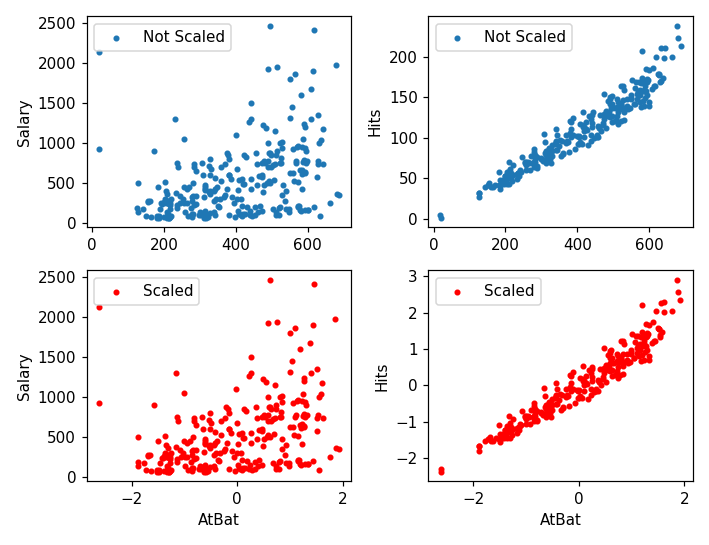

In [47]:
# Visualize feature scaling
%matplotlib notebook
fig, ax = plt.subplots(2,2,figsize=(6.5,5))
#ax[0, 0].scatter(x_sc[:, 0], y, label = 'Scaled', marker = '.')
ax[0, 0].scatter(x[:, 0], y, label = 'Not Scaled', marker = '.')
ax[0, 0].legend()
ax[0, 0].set_ylabel('Salary')
#ax[0, 0].set_xlabel(features[0])

ax[1, 0].scatter(x_sc[:, 0], y, label = 'Scaled', marker = '.', color = 'r')
#ax[1, 0].scatter(x[:, 0], y, label = 'Not Scaled', marker = '.')
ax[1, 0].legend()
ax[1, 0].set_ylabel('Salary')
ax[1, 0].set_xlabel(features[0])

#ax[0, 1].scatter(x_sc[:, 0], x_sc[:, 1], label = 'Scaled', marker = '.')
ax[0, 1].scatter(x[:, 0], x[:, 1], label = 'Not Scaled', marker = '.')
ax[0, 1].legend()
ax[0, 1].set_ylabel(features[1])
#ax[0, 1].set_xlabel(features[0])

ax[1, 1].scatter(x_sc[:, 0], x_sc[:, 1], label = 'Scaled', marker = '.', color = 'r')
#ax[1, 1].scatter(x[:, 0], x[:, 1], label = 'Not Scaled', marker = '.')
ax[1, 1].legend()
ax[1, 1].set_ylabel(features[1])
ax[1, 1].set_xlabel(features[0])


plt.tight_layout()

In [49]:
# Fit and transform
x_sc_pca = model_pca.fit_transform(x_sc)

In [62]:
# Look at first 5 principal components
model_pca.components_[:, :5]

array([[ 0.19829035,  0.19586129,  0.20436892,  0.19833709,  0.2351738 ],
       [-0.38378403, -0.37727112, -0.23713561, -0.37772134, -0.3145312 ],
       [ 0.08862593,  0.07403226, -0.21618563, -0.01716642, -0.07308534],
       [ 0.03196743,  0.01798235, -0.23583077, -0.0499415 , -0.13898526],
       [ 0.02811656, -0.0046521 ,  0.07765965, -0.03853613,  0.02429912],
       [-0.0706459 , -0.08223996, -0.14964597, -0.13666025, -0.11167526],
       [ 0.10704363,  0.13002617, -0.50583292,  0.20176406, -0.31943967],
       [ 0.26980952,  0.38872179, -0.22627833,  0.11451775,  0.00508239],
       [-0.0121833 , -0.06160416,  0.12742237, -0.17123036,  0.13114612],
       [ 0.1456213 ,  0.13047605, -0.35111143,  0.03224513, -0.17223297],
       [ 0.09732836,  0.01443297, -0.20218997, -0.31218685,  0.24341505],
       [ 0.10314991,  0.12100863, -0.31485213, -0.32169964,  0.34775194],
       [-0.03985028,  0.00359312, -0.10868861, -0.38121887,  0.44014293],
       [ 0.30624808,  0.2106161 , -0.0

In [120]:
model_pca = PCA()
# Feature Scaling
sc = StandardScaler()
x_sc = sc.fit_transform(x)
x_sc_pca = model_pca.fit_transform(x_sc)

LR = LinearRegression()

In [137]:
# Compute the ten-fold cross-validation error
# Without pipeline
results1 = []
for i in range(1, len(features)+1):
    
    model_pca = PCA(n_components=i)
    # Feature Scaling
    sc = StandardScaler()
    
    # Fit and transform
    x_sc = sc.fit_transform(x)
    
    # Principal components
    x_sc_pca = model_pca.fit_transform(x_sc)
    
    # Linear regression model
    LR = LinearRegression()

    # Note cross val score has no mean_squared_error scoring! instead negative root MSE!
    # List of scoring can be found using sorted(sklearn.metrics.SCORERS.keys())
    score = cross_val_score(LR, x_sc_pca, y, scoring='neg_root_mean_squared_error', cv = 10)
    
    results1.append(np.mean(score**2))


In [162]:
# Compute the ten-fold cross-validation error
# with Pipeline
results2 = []
variance_percentage = []
for i in range(1, len(features)+1):
    
    model_pca = PCA(n_components=i)
    pipeline = Pipeline([('Scaling',  sc), ('PCA', model_pca), ('linear_regression', LR)])
    pipeline.fit(x, y)


    # Note cross val score has no mean_squared_error scoring! instead negative root MSE!
    # List of scoring can be found using sorted(sklearn.metrics.SCORERS.keys())
    score = cross_val_score(pipeline, x, y, scoring='neg_root_mean_squared_error', cv = 10)
    results2.append(np.mean(score**2))
    variance_percentage.append(np.sum(model_pca.explained_variance_ratio_)*100)

<IPython.core.display.Javascript object>


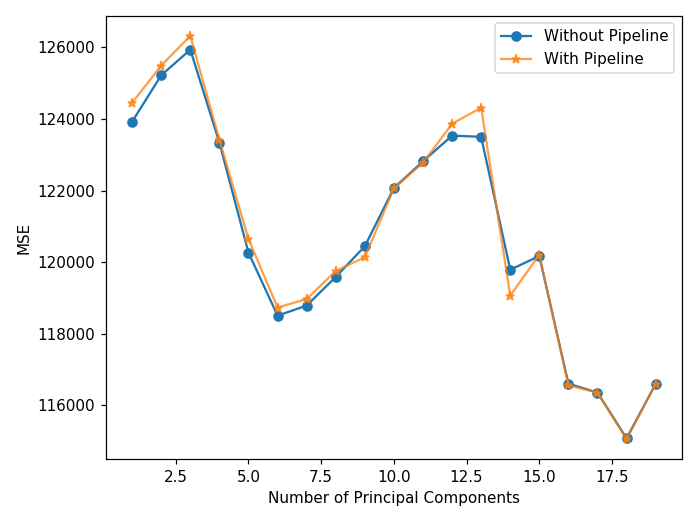

In [165]:
%matplotlib notebook
plt.plot(range(1, len(features)+1), results1, label = 'Without Pipeline', marker= 'o')
plt.plot(range(1, len(features)+1), results2, alpha = 0.75, label = 'With Pipeline', marker = '*')
plt.legend()
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.tight_layout()
plt.savefig('MSE_vs_principal_components.png', dp1 = 100)

<IPython.core.display.Javascript object>


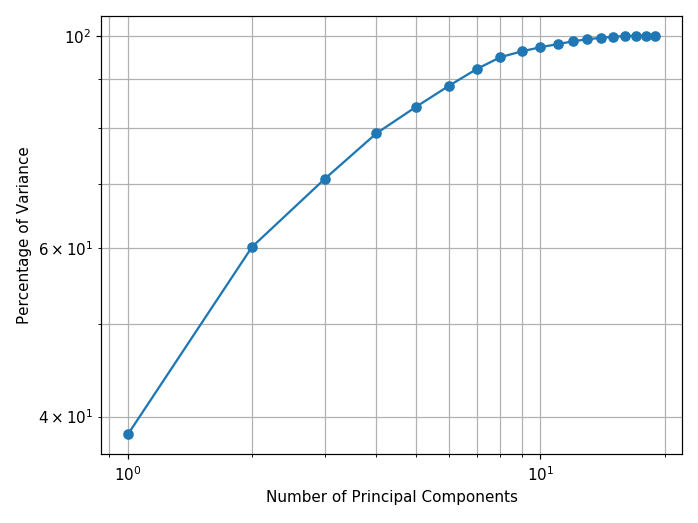

In [193]:
# Now lets plot percentage of variance explained
# in the predictors and in the response using different numbers of components
""" we can think of this as the amount of information about the predictors or
    the response that is captured using M principal components. For example,
    setting M = 1 only captures 38.31% of all the variance, or information, in
    the predictors. In contrast, using M = 6 increases the value to 88.63%. If
    we were to use all M = p = 19 components, this would increase to 100%."""

%matplotlib notebook
plt.plot(range(1, len(features)+1), variance_percentage, marker= 'o')
plt.semilogx()
plt.semilogy()
plt.grid(which = 'both')
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage of Variance')
plt.tight_layout()
plt.savefig('percentage_of_variance_vs_components.png', dpi = 100)

We now perform PCR on the training data and evaluate its test set performance.

In [230]:
#Validation set approach, we randomly split the data into training and test datasets 
np.random.seed(0)
index = np.random.choice([True, False], size=len(df))
df_train = df[index]
df_test = df[~index]

In [231]:
print('Shape of the whole dataset: {}'.format(df.shape))
print('Shape of training dataset: {}'.format(df_train.shape))
print('Shape of test dataset: {}'.format(df_test.shape))

Shape of the whole dataset: (263, 20)
Shape of training dataset: (130, 20)
Shape of test dataset: (133, 20)


In [232]:
x_train = df_train[features].values
y_train = df_train['Salary'].values
x_test = df_test[features].values
y_test = df_test['Salary'].values

In [233]:
# Compute the ten-fold cross-validation error
# with Pipeline
results = []
variance_percentage = []
for i in range(1, len(features)+1):
    
    model_pca = PCA(n_components=i)
    pipeline = Pipeline([('Scaling',  sc), ('PCA', model_pca), ('linear_regression', LR)])
    pipeline.fit(x_train, y_train)


    # Note cross val score has no mean_squared_error scoring! instead negative root MSE!
    # List of scoring can be found using sorted(sklearn.metrics.SCORERS.keys())
    score = cross_val_score(pipeline, x_train, y_train, scoring='neg_root_mean_squared_error', cv = 10)
    results.append(np.mean(score**2))
    variance_percentage.append(np.sum(model_pca.explained_variance_ratio_)*100)

<IPython.core.display.Javascript object>


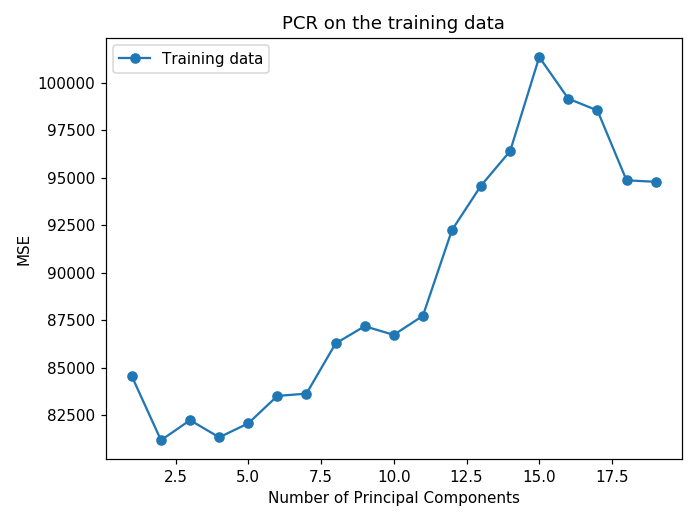

In [238]:
%matplotlib notebook
plt.plot(range(1, len(features)+1), results, label = 'Training data', marker= 'o')
plt.legend()
plt.title('PCR on the training data')
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.tight_layout()
plt.savefig('MSE_vs_principal_components_training_data.png', dp1 = 100)

<IPython.core.display.Javascript object>


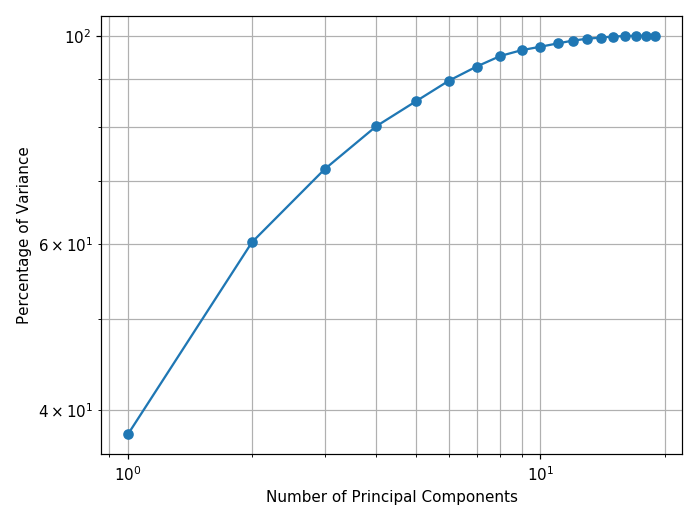

In [235]:
# Now lets plot percentage of variance explained
%matplotlib notebook
plt.plot(range(1, len(features)+1), variance_percentage, marker= 'o')
plt.semilogx()
plt.semilogy()
plt.grid(which = 'both')
plt.xlabel('Number of Principal Components')
plt.ylabel('Percentage of Variance')
plt.tight_layout()
plt.savefig('percentage_of_variance_vs_components_training_data.png', dpi = 100)

In [237]:
#Let's use 4 principal components as with 4 we capture 80% of all the variance.

model_pca = PCA(n_components=4)
pipeline = Pipeline([('Scaling',  sc), ('PCA', model_pca), ('linear_regression', LR)])
pipeline.fit(x_train, y_train)
predictions = pipeline.predict(x_test)

np.mean((predictions - y_test)**2)

160962.8564265933